In [1]:
try:
    import google.colab
    from google.colab import files
    files.upload()
    ! pip install -q kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    ! kaggle datasets download -d chrisfilo/urbansound8k
    ! unzip urbansound8k.zip -d UrbanSounds8K
    !pip install ipytest
    
except:
    pass

In [26]:
import ipytest
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchaudio
import random
import numpy as np
import os
import Augmentation

augmentor = Augmentation.Augmentor()

ipytest.autoconfig()

class_map = [
    'air conditioner', 'car horn', 'children playing', 'dog bark', 'drilling',
    'engine idling', 'gunshot', 'jackhammer', 'siren', 'street music'
]

def load_audio_files(path, dataset):
    walker = [str(p) for p in Path(path).glob(f'*.wav')]
    for i, file_path in enumerate(walker,):
        path, filename = os.path.split(file_path)
        title, _ = os.path.splitext(filename)
        fsID, classID, occurrenceID, sliceID = [
            int(n) for n in title.split('-')
        ]
        # Load audio
        waveform, sample_rate = augmentor.pad_trunc(
            augmentor.resample(augmentor.rechannel(
                torchaudio.load(file_path))))
        assert waveform.shape == torch.Size(
            [1, 176400]), f'Error: waveform shape is {waveform.shape}'
        dataset.append([waveform[0], classID, title])

    return dataset

def create_spectrogram_images(trainloader, mode = "train"):
    length = len(trainloader)
    spectrogram = torchaudio.transforms.Spectrogram()
    timeMask = torchaudio.transforms.TimeMasking(time_mask_param=80)
    freqMask = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
    num_TimeMask = 4
    num_FreqMask = 4
    num_FreqTimeMask = 4

    for i, data in enumerate(trainloader):
        waveform = data[0]
        classID = data[1].item()
        title = data[2][0]
        directory = f'./UrbanSounds8K/spectrograms/{mode}/{class_map[classID]}/'
        if(not os.path.isdir(directory)):
            os.makedirs(directory, mode=0o777, exist_ok=True)

        spectrogram_tensor = (spectrogram(waveform) + 1e-12).log2()

        assert spectrogram_tensor.shape == torch.Size([1, 201, 883]), f"Spectrogram size mismatch! {spectrogram_tensor.shape}"

        if mode == "train":
            # create transformed waveforms
            for a in range(num_TimeMask):
                masked_spectrogram_tensor = timeMask(spectrogram_tensor)
                np.save(f'{directory}{title}-tm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqMask):
                masked_spectrogram_tensor = freqMask(spectrogram_tensor)
                np.save(f'{directory}{title}-fm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqTimeMask):
                masked_spectrogram_tensor = freqMask(timeMask(spectrogram_tensor))
                np.save(f'{directory}{title}-ftm{a}_spec',
                        masked_spectrogram_tensor.flipud())

        np.save(f'{directory}{title}-org_spec', spectrogram_tensor.flipud())
        # break
        if i % 1000 == 0:
            print(f'{mode}: {i}/{length}')

    return (length)*(num_TimeMask + num_FreqMask + num_FreqTimeMask + 1) if mode=="train" else (length)


In [3]:
%%ipytest

def test_load():
    walker = sorted(str(p) for p in Path("./test/").glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        assert torchaudio.load(file_path) 

def test_pad_trunc():
    target_length = 4
    assert len(augmentor.pad_trunc(torchaudio.load('./test/1_44100_0830.wav'))[0][0]) == 44100*target_length
    assert len(augmentor.pad_trunc(torchaudio.load('./test/2_44100_2250.wav'))[0][0]) == 44100*target_length
    assert len(augmentor.pad_trunc(torchaudio.load('./test/2_44100_4000.wav'))[0][0]) == 44100*target_length

def test_rechannel():
    target_channel = 1
    assert augmentor.rechannel(torchaudio.load('./test/1_44100_0830.wav'))[0].shape[0] == target_channel
    assert augmentor.rechannel(torchaudio.load('./test/2_44100_4000.wav'))[0].shape[0] == target_channel

def test_resample():
    target_sr = 44100
    assert len(augmentor.resample(torchaudio.load('./test/1_11025_4000.wav'))[0][0]) == 4*target_sr
    assert len(augmentor.resample(torchaudio.load('./test/1_44100_0830.wav'))[0][0]) == 0.830*target_sr
    assert len(augmentor.resample(torchaudio.load('./test/1_96000_0310.wav'))[0][0]) == 0.310*target_sr


....                                                                                         [100%]
4 passed in 0.08s


In [4]:
main_path = './UrbanSounds8K/'
directory = [str(p) for p in Path(main_path).glob('fold*')]

audio_dataset = []

for path in directory[0:8]:
    print("Loading ", path)
    audio_dataset = load_audio_files(path, audio_dataset)

test_dataset=[]
test_dataset = load_audio_files(directory[9], test_dataset)

print(f"Length of dataset: {len(audio_dataset)}")

Loading  UrbanSounds8K\fold1
Loading  UrbanSounds8K\fold10
Loading  UrbanSounds8K\fold2
Loading  UrbanSounds8K\fold3
Loading  UrbanSounds8K\fold4
Loading  UrbanSounds8K\fold5
Loading  UrbanSounds8K\fold6
Loading  UrbanSounds8K\fold7
Length of dataset: 7110


In [5]:
train_size = int(0.8 * len(audio_dataset))

val_size = len(audio_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    audio_dataset, [train_size, val_size])

# Load training set
audio_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

num_train = create_spectrogram_images(audio_dataloader, "train")

# Load validating set
audio_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

num_val = create_spectrogram_images(audio_dataloader, "val")


# Load testing set
audio_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

num_test = create_spectrogram_images(audio_dataloader, "test")

train: 0/5688
train: 1000/5688
train: 2000/5688
train: 3000/5688
train: 4000/5688
train: 5000/5688
val: 0/1422
val: 1000/1422
test: 0/816


In [7]:
%%ipytest

def test_spectrogram_generation_train():
    assert len([
        str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')
    ]) == len(class_map)

    sum = 0
    dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')]
    for path in dir:
        num = len([str(p) for p in Path(path).glob('*')])
        sum += num
    assert sum == num_train

def test_spectrogram_generation_val():
    assert len([
        str(p) for p in Path('./UrbanSounds8K/spectrograms/val').glob('*')
    ]) == len(class_map)

    sum = 0
    dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/val').glob('*')]
    for path in dir:
        num = len([str(p) for p in Path(path).glob('*')])
        sum += num

    assert sum == num_val

def test_spectrogram_generation_test():
    sum = 0
    dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/test').glob('*')]
    for path in dir:
        num = len([str(p) for p in Path(path).glob('*')])
        sum += num

    assert sum == num_test

FFF                                                                                          [100%]
============================================ FAILURES =============================================
________________________________ test_spectrogram_generation_train ________________________________

    def test_spectrogram_generation_train():
        assert len([
            str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')
        ]) == len(class_map)
    
        sum = 0
        dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')]
        for path in dir:
            num = len([str(p) for p in Path(path).glob('*')])
            sum += num
>       assert sum == num_train
E       assert 97032 == 73944

C:\Users\JianQuan\AppData\Local\Temp\ipykernel_5228\1425346925.py:11: AssertionError
_________________________________ test_spectrogram_generation_val _________________________________

    def test_spectrogram_generation_val():
        assert 

-39.863136   12.575571


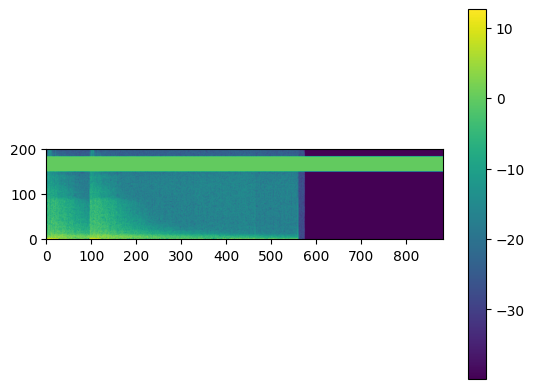

In [8]:
# maybe autoload the first file

test_load = np.load(
    './UrbanSounds8K/spectrograms/train/gunshot/102305-6-0-0-fm0_spec.npy')
plt.imshow(test_load[0], origin="lower")
plt.colorbar()
print(test_load.min(), " ", test_load.max())

Debug

In [ ]:
# filename = "./UrbanSounds8K/fold1/102305-6-0-0.wav"
# waveform, sample_rate = rechannel(torchaudio.load(filename), 1)
# fig, axs = plt.subplots(2)
# axs[0].plot(waveform.t().numpy())
# show_spectrogram(waveform)

In [ ]:
# waveform, sr = pad_trunc(rechannel(torchaudio.load(filename), 1), 4000)
# fig, axs = plt.subplots(2)
# axs[0].plot(waveform.t().numpy())
# show_spectrogram(waveform)

In [ ]:
# audio_dataset = []
# sum = 0

# main_path = './UrbanSounds8K/spectrograms/'

# dir = [str(p) for p in Path(main_path).glob('*')]
# for path in dir:
#   print('Loading: '+ path)
#   num = len([str(p) for p in Path(path).glob('*')])
#   sum += num
#   print(num)

# sum